In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
from pathlib import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
sys.path.append("../src/")
from data import ResponseData
import corner
from bayes import run_multinest
from posterior import Posterior
from model import Model, LogpolyModel, EmpiricalPoisson, FitNoise, Gsf3Model, ConstantNoise, GaussianNoise, ExponentialNoise, HalfNormalNoise, EmpiricalNoise
from bayesian_regression import posterior_predictions
from marginal import marginal_plot, single_marginal
from utils import newfig, savefig

DATAPATH = Path("../data/")

In [6]:
plt.style.use(DATAPATH / 'rapport.mplstyle')
plt.rcParams['axes.grid'] = False

In [2]:
def gridon():
    plt.rcParams['axes.grid'] = True
def gridoff():
    plt.rcParams['axes.grid'] = False

# Plotting

## DE

### Fit sigma

In [109]:
model = LogpolyModel(order=2) + FitNoise(lambda unit: 0.1*unit)
data = ResponseData(model, label='DE')
data.cut(E_low=2000, E_high=10000)
run_multinest(data, n_live_points=500);

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
  analysing data from DElogpoly2FN[0.1]/mn_.txt ln(ev)=  -23.635192241861215      +/-  0.20945395280448090     
 Total Likelihood Evaluations:        25904
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


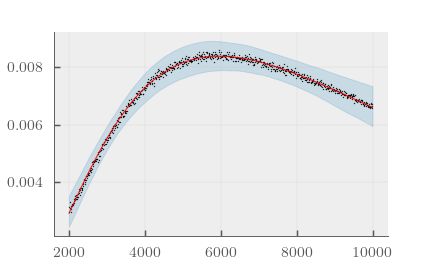

In [110]:
post = Posterior(data)
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.1)
data.plot(ax=ax, log=False, color='k', s=0.05)
post.plot(ax=ax, color='r', quantile=None)
post.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'fit_de.pdf')
gridoff()

<IPython.core.display.Javascript object>


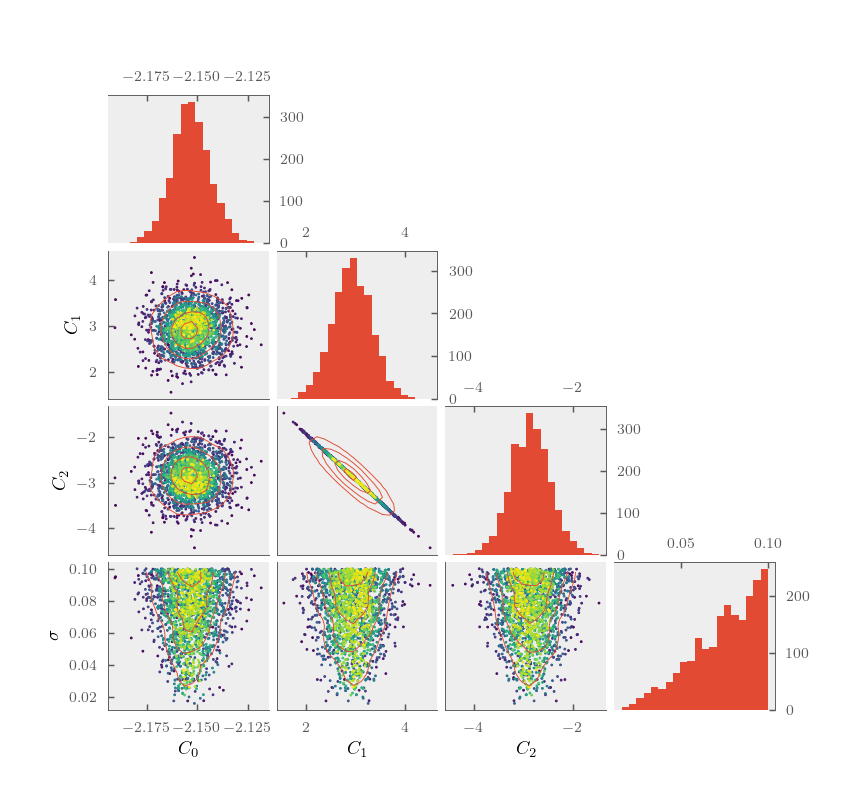

/home/erdos/gits/CompSci3/notebooks/../src/marginal.py:100: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0.05, hspace=0.05)


In [116]:
fig = newfig(height=3, width=2, addax=False, constrained_layout=True)
marginal_plot(post, fig=fig, contourkw={'colors': 'C0'})
savefig(fig, 'fit_marginal_de.pdf')

In [178]:
np.exp(0.087)

1.0908966797182778

### Constant sigma

In [75]:

datas = []
sigmas = [1, 0.1, 0.01, 0.001, 0.0001]
for i, sigma in enumerate(sigmas):
    model = LogpolyModel(order=2) + ConstantNoise(sigma)
    data = ResponseData(model, label='DE')
    data.cut(E_low=2000, E_high=10000)
    run_multinest(data, n_live_points=500);
    datas.append(data) 

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN1/mn_.txt ln(ev)=  -19.185596866443174      +/-  0.18829431835761160     
 Total Likelihood Evaluations:        15851
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN0.1/mn_.txt ln(ev)=  -23.154739253548314      +/-  0.20749584009778105     
 Total Likelihood Evaluations:        16281
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points

In [76]:
posteriors = [Posterior(d) for d in datas]

<IPython.core.display.Javascript object>


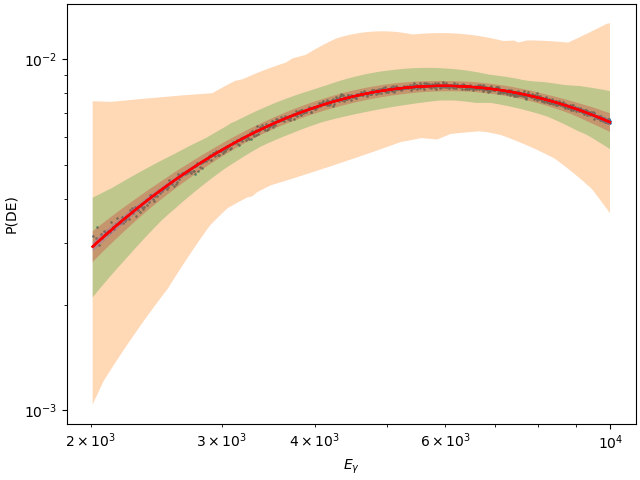

In [99]:

fig, ax = plt.subplots(constrained_layout=True)
data.plot(ax=ax)
for post in posteriors:
    post.plot(ax=ax, quantile=0.001)

In [120]:
def bifurcate(maxit=10, l=1e-3, h=1e-1):
    posts = []
    i = 0
    while i < maxit:
        sigma = (h+l)/2
        print(f"{i}: {sigma}")
        model = LogpolyModel(order=2) + ConstantNoise(sigma)
        data = ResponseData(model, label='DE')
        data.cut(E_low=2000, E_high=10000)
        run_multinest(data, n_live_points=500);
        posts.append(Posterior(data))
        score = posts[-1].assess()
        print(f'score: {score}')
        if score < 1:
            l = sigma
        elif score > 1:
            h = sigma
        else:
            print("Equal")
            break
        i += 1
    return sigma, score, posts
    

In [121]:
sigma, score, posts = bifurcate(15)

0: 0.0505
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN0.0505/mn_.txt ln(ev)=  -24.336327257110216      +/-  0.21225856266393764     
 Total Likelihood Evaluations:        15988
 Sampling finished. Exiting MultiNest

score: 1.0526315789473684
1: 0.025750000000000002
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN0.025750000000000002/mn_.txt ln(ev)=  -25.528982011621878      +/-  0.21703025707367163     
 Total Likelihood Evaluations:        16963
 Sampling finished. Exiting MultiNest

score: 1.0499967064093274
2: 0.013375000000000001
 ***************

In [179]:
np.exp(0.00894)

1.0089800811527982

In [125]:
for p in posts:
    print(p.data.model.noise.sigma)
    p._assess()
    print()

0.0505
0.950: 1.000 1.0526315789473684
0.990: 1.000 1.0101010101010102
0.999: 1.000 1.001001001001001

0.025750000000000002
0.950: 0.997 1.0499967064093274
0.990: 1.000 1.0101010101010102
0.999: 1.000 1.001001001001001

0.013375000000000001
0.950: 0.985 1.0368223437191226
0.990: 0.996 1.0063083905386783
0.999: 1.000 1.001001001001001

0.007187500000000001
0.950: 0.922 0.9709505302680984
0.990: 0.984 0.9936663253309062
0.999: 0.995 0.9959897319096318

0.010281250000000002
0.950: 0.972 1.0236479810289176
0.990: 0.995 1.0050441840179012
0.999: 0.997 0.9984953664553164

0.008734375000000003
0.950: 0.940 0.9893946380343852
0.990: 0.990 0.9999873579347922
0.999: 0.997 0.9984953664553164

0.009507812500000002
0.950: 0.952 1.00256900072459
0.990: 0.991 1.0012515644555695
0.999: 0.996 0.997242549182474

0.009121093750000003
0.950: 0.955 1.005203873262631
0.990: 0.991 1.0012515644555695
0.999: 0.996 0.997242549182474

0.008927734375000003
0.950: 0.946 0.9959818193794875
0.990: 0.987 0.9974589448

<IPython.core.display.Javascript object>


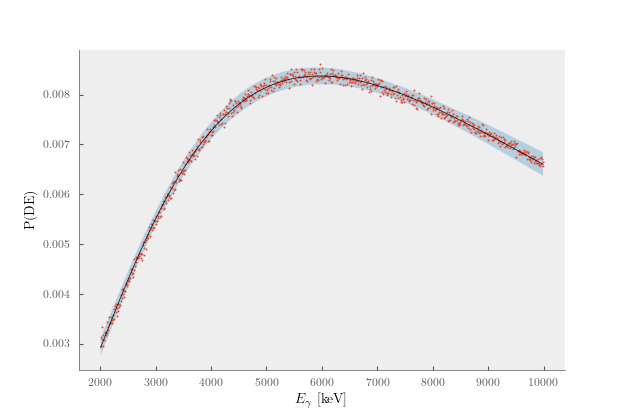

In [180]:

fig, ax = newfig()
data.plot(ax=ax, log=False)
posts[-2].plot(ax=ax, quantile=0.05, color='k')
savefig(fig, 'constant_optimal_de.pdf')

<IPython.core.display.Javascript object>


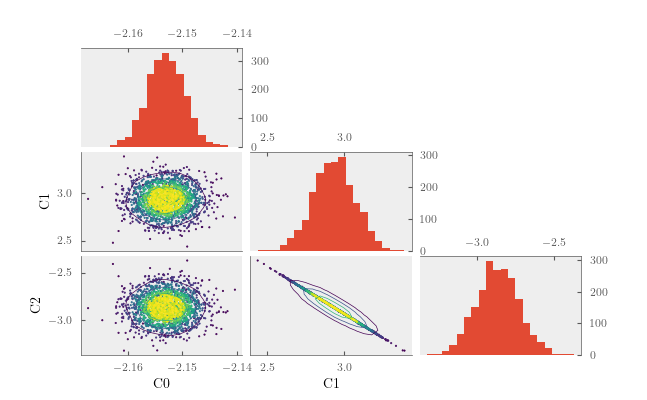

In [173]:

fig = newfig(N=2, addax=False)
marginal_plot(posts[-2], fig=fig)
savefig(fig, 'constant_optimal_marginal_de.pdf')

### Fitting sigma to data

In [121]:
import scipy as sci
import scipy.signal as sig
from scipy import stats
import scipy.optimize as opt
def rollavg_convolve_edges(a,n):
    'scipy.convolve, edge handling'
    assert n%2==1
    return sci.convolve(a,np.ones(n,dtype='float'), 'same')/sci.convolve(np.ones(len(a)),np.ones(n), 'same')

In [192]:
def measure_sigma(label, l=0, h=None, window=27, log=True, save=True):
    model = LogpolyModel(order=5) + ConstantNoise(0.1)
    data = ResponseData(model, label=label)
    if label == 'DE':
        data.cut(E_low=2000, E_high=10000)
    x = data.x
    y = data.y
    if log:
        y = np.log10(y)
    yh = rollavg_convolve_edges(y, window)
    y = y[l:h]
    yh = yh[l:h]
    x = x[l:h]
    fig, (ax1, ax2) = newfig(nrows=2, sharex=True, constrained_layout=True)
    ax1.plot(x, y, 'o', markersize=0.3, label='Data')
    ax1.plot(x, yh, 'k', label='Rolling average')
    ax2.plot(x, y -yh)
    ax2.set_xlabel(r'$E_{\gamma}$ [keV]')
    ax2.set_ylabel(r'$y - y_{\mathrm{mean}}$')
    ax1.set_ylabel('P(DE)')
    ax1.legend()
    if save:
        savefig(fig, 'rolling_average.pdf')
    
    fig, ax = newfig(constrained_layout=True)
    ax.plot(x, np.abs(y -yh))
    
    res = np.abs(y - yh)
    mu = np.mean(res)
    sigma = np.std(res)
    print(f'{mu=:.9f}')
    print(f'{sigma=:.9f}')
    fig, ax = plt.subplots()
    h, bins, p = ax.hist(res, bins=100, density=True, histtype='step', color='k',
                         label=r'$|y - y_{\mathrm{mean}}|$', alpha=0.5)
    sigma_ = np.std(y- yh)
    g = gauss(bins, 1, mu, sigma)
    ax.plot(bins, g, label='Normal', lw=1)
    se = sigma / (np.sqrt(2*len(y) - 2))
    g = gauss(bins, 1, sigma_, se)
    print(f'{sigma_=:.9f}')
    print(f'{se=:.9f}')
    ylim = ax.get_ylim()
    ax.plot(bins, g, label="Normal SE", lw=1)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Density')
    
    mid = (bins + (bins[1] - bins[0])/2)[:-1]
    def fit(dist, p0):
        popt,pcov = opt.curve_fit(lambda x,l,s: dist.pdf(x,l,s), mid,h, p0=p0)
        print(popt)
        return popt
    loc, scale = fit(stats.expon, [0.0, sigma])
    expon = stats.expon.pdf(bins, loc, scale)
    ax.plot(bins, expon, label='Exponential', lw=1)
    loc, scale = fit(stats.halfnorm, [0.0, sigma])
    hn = stats.halfnorm.pdf(bins, loc, scale)
    ax.plot(bins, hn, label='HalfNormal', color='C6', lw=1)
    ax.legend()
    if save:
        savefig(fig, "priors.pdf")
    
    res = y - yh
    mu = np.mean(res)
    sigma = np.std(res)
    print(f'{mu=:.9f}')
    print(f'{sigma=:.9f}')
    fig, ax = newfig(constrained_layout=True)
    h, bins, p = ax.hist(res, bins=50, density=True, histtype='step')
    g = gauss(bins, 1, mu, sigma)
    ax.plot(bins, g)
    ax.set_xlabel(r'$|y - y_{\mathrm{mean}}|$')
    ax.set_ylabel('Density')
    if save:
        savefig(fig, "y_rolling_hist.pdf")
    return res, mu, sigma

In [193]:
def gauss(x, A, mu, sigma):
    return A * 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-1/2*(x-mu)**2/sigma**2)

/tmp/ipykernel_198989/1281746658.py:8: DeprecationWarning: scipy.convolve is deprecated and will be removed in SciPy 2.0.0, use numpy.convolve instead
  return sci.convolve(a,np.ones(n,dtype='float'), 'same')/sci.convolve(np.ones(len(a)),np.ones(n), 'same')


<IPython.core.display.Javascript object>


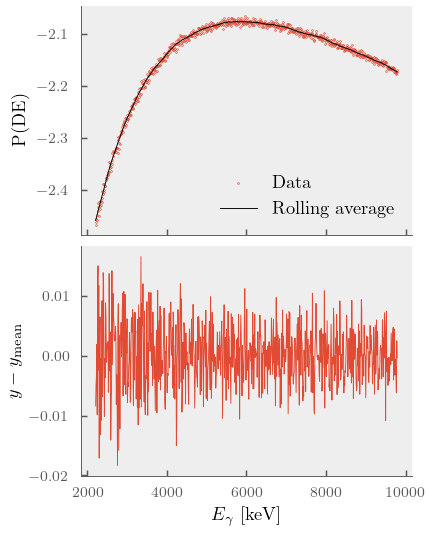

<IPython.core.display.Javascript object>


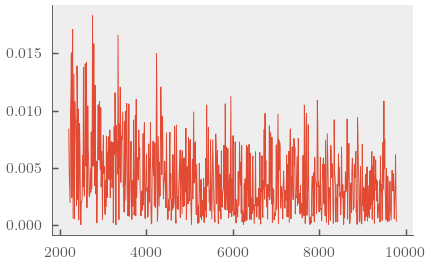

mu=0.003925290
sigma=0.003113206


<IPython.core.display.Javascript object>


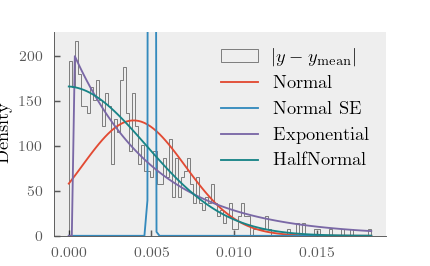

sigma_=0.005008753
se=0.000079957
[0.00027794 0.00492067]
[-0.00013387  0.00481047]
mu=0.000111117
sigma=0.005008753


<IPython.core.display.Javascript object>


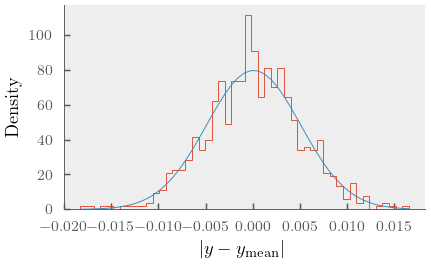

In [199]:
res, my, sigma = measure_sigma('DE', l=20, h=-20, log=True, save=False)

In [190]:
sigma=0.005008753
10**sigma

1.0115998423711003

### Using sigma from data

In [7]:
sigma = 0.0115
model = LogpolyModel(order=2) + ConstantNoise(sigma)
data = ResponseData(model, label='DE')
data.cut(E_low=2000, E_high=10000)
run_multinest(data, n_live_points=500);
post = Posterior(data)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN0.0115/mn_.txt ln(ev)=  -27.248701046098887      +/-  0.22179726163995317     
 Total Likelihood Evaluations:        19051
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


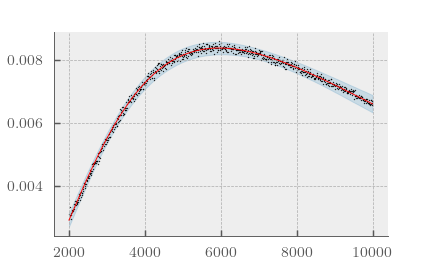

In [52]:
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.4)
data.plot(ax=ax, log=False, color='k', s=0.05)
post.plot(ax=ax, color='r', quantile=None)
post.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'constant_optimal_de.pdf')
gridoff()

<IPython.core.display.Javascript object>


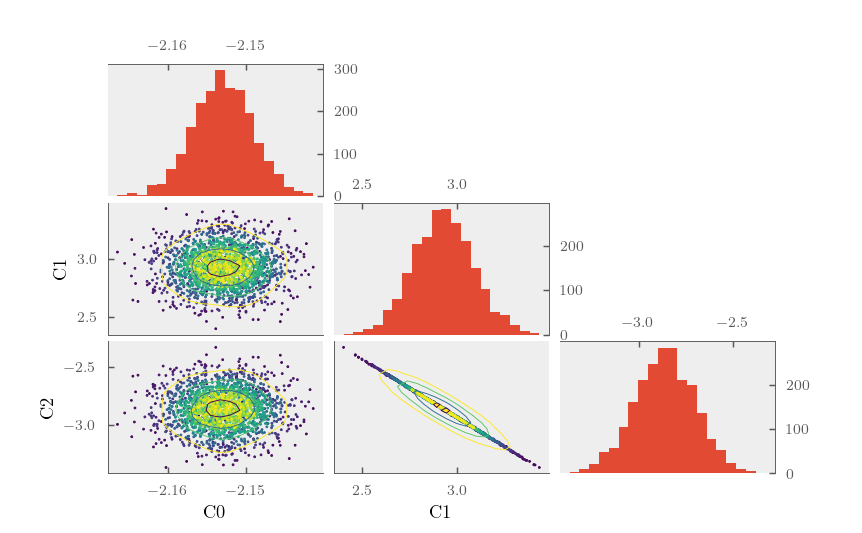

In [54]:
fig = newfig(N=2, addax=False)
marginal_plot(post, fig=fig, contourkw={'cmap': 'viridis_r', 'smooth': 1})
savefig(fig, 'constant_optimal_marginal_de.pdf')

### Empirical sigma

In [103]:
model = LogpolyModel(order=2) + EmpiricalPoisson()
data_emp = ResponseData(model, label='DE')
data_emp.cut(E_low=2000, E_high=10000)
run_multinest(data_emp, n_live_points=500);

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2EP/mn_.txt ln(ev)=  -16.955646293116068      +/-  0.17567202928115172     
 Total Likelihood Evaluations:        13180
 Sampling finished. Exiting MultiNest



In [105]:
post_emp = Posterior(data_emp)
print(post_emp.summary())

Posterior for LogpolyModel + EmpiricalPoisson
Nested sampling global log evidence:            -16.95564629 ± 0.17567203
Nested importance sampling global log evidence: -17.08586012 ± 0.01819429

Param        Mean               Std
C0           -2.15328293   ± 0.07626037
C1           2.96511248    ± 3.24328949
C2           -2.89804083   ± 3.23704385

Param         Maximum Likelihood \ MAP
C0           -2.14951951e+00
C1           2.83448406e+00
C2           -2.77439292e+00

None


In [106]:
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.1)
data_emp.plot(ax=ax, log=False, color='k', s=0.05)
post_emp.plot(ax=ax, color='r', quantile=None)
post_emp.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'empirical_de.pdf')
gridoff()

<IPython.core.display.Javascript object>

In [108]:
fig = newfig(N=2, addax=False)
f, axd = marginal_plot(post_emp, fig=fig)
for _, ax in axd.items():
    ax.grid(False)
savefig(fig, 'empirical_marginal_de.pdf')

<IPython.core.display.Javascript object>

### Gaussian Noise

In [73]:
mu = 0.005
sigma = 0.001
sigma = mu / np.sqrt(2*799 - 2)
print(sigma)
model = LogpolyModel(order=2) + GaussianNoise(mu, sigma)
data = ResponseData(model, label='DE')
data.cut(E_low=2000, E_high=10000)
run_multinest(data, n_live_points=2000);

0.00012515654358043974
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 2000
 dimensionality =    4
 *****************************************************
  analysing data from DElogpoly2GN0.0050.00012515654358043974/mn_.txt ln(ev)=  -30.010741866949381      +/-  0.11376841936743885     
 Total Likelihood Evaluations:       105624
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


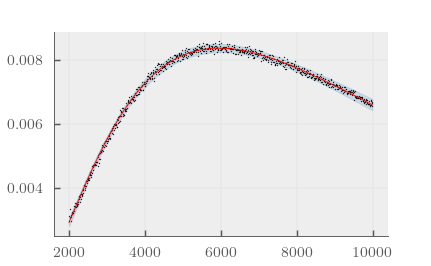

In [90]:
post = Posterior(data)
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.1)
data.plot(ax=ax, log=False, color='k', s=0.05)
post.plot(ax=ax, color='r', quantile=None)
post.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'gauss_sharp_de.pdf')
gridoff()

Posterior for LogpolyModel + GaussianNoise
Nested sampling global log evidence:            -29.74965109 ± 0.22627583
Nested importance sampling global log evidence: -30.01438007 ± 0.01744465

Param        Mean               Std
C0           -2.15305048   ± 0.00252303
C1           2.93378329    ± 0.10421784
C2           -2.86735629   ± 0.10427125
sigma        0.00501825    ± 0.00012186

Param         Maximum Likelihood \ MAP
C0           -2.15342145e+00
C1           2.96791550e+00
C2           -2.90197320e+00
sigma        5.36431718e-03



<IPython.core.display.Javascript object>


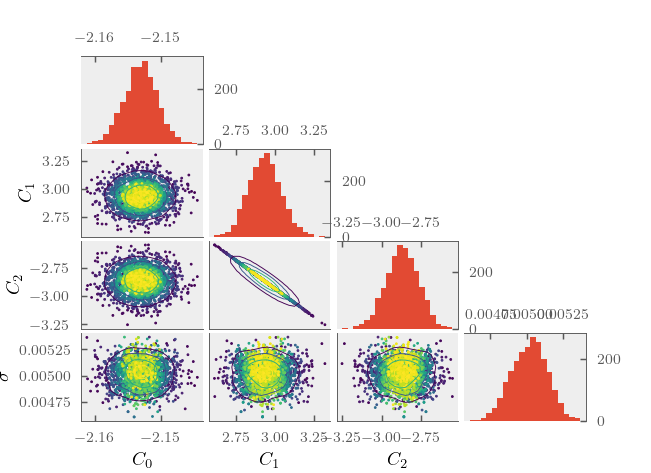

(<Figure size 322.54x199.34 with 10 Axes>,
 {'00': <AxesSubplot:label='00'>,
  '10': <AxesSubplot:label='10', ylabel='$C_{1}$'>,
  '11': <AxesSubplot:label='11'>,
  '20': <AxesSubplot:label='20', ylabel='$C_{2}$'>,
  '21': <AxesSubplot:label='21'>,
  '22': <AxesSubplot:label='22'>,
  '30': <AxesSubplot:label='30', xlabel='$C_{0}$', ylabel='$\\sigma$'>,
  '31': <AxesSubplot:label='31', xlabel='$C_{1}$'>,
  '32': <AxesSubplot:label='32', xlabel='$C_{2}$'>,
  '33': <AxesSubplot:label='33'>})

In [64]:
print(post.summary())
marginal_plot(post);

<IPython.core.display.Javascript object>


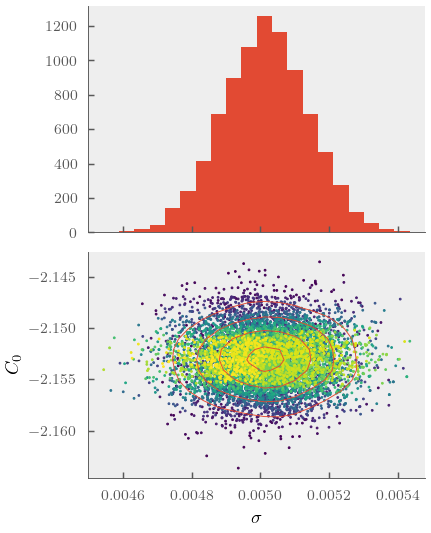

In [89]:
fig = newfig(height=2, addax=False, constrained_layout=True)
single_marginal(post, 'sigma', 'C0', fig=fig, contourkw={'colors': 'C0'})
savefig(fig, 'gauss_sharp_marginal_de.pdf')

In [198]:
(1+10000)**(--10)

10010004501200210025202100120004500100001

### Exponential Noise

In [91]:
mu, sigma = [0.0001963,  0.00502072]
model = LogpolyModel(order=2) + ExponentialNoise(mu, sigma)
data_exp = ResponseData(model, label='DE')
data_exp.cut(E_low=2000, E_high=10000)
run_multinest(data_exp, n_live_points=2000);
post_exp = Posterior(data_exp)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 2000
 dimensionality =    4
 *****************************************************
  analysing data from DElogpoly2Exp0.00019630.00502072/mn_.txt ln(ev)=  -27.392612437849746      +/-  0.11171441211252409     
 Total Likelihood Evaluations:       139789
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


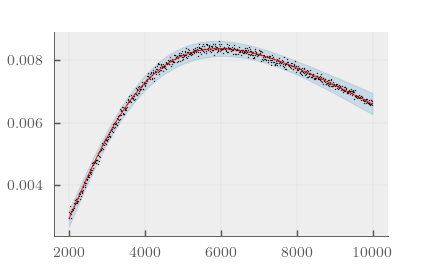

In [92]:
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.1)
data_exp.plot(ax=ax, log=False, color='k', s=0.05)
post_exp.plot(ax=ax, color='r', quantile=None)
post_exp.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'exponential_de.pdf')
gridoff()

Posterior for LogpolyModel + ExponentialNoise
Nested sampling global log evidence:            -27.39261244 ± 0.11171441
Nested importance sampling global log evidence: -27.76734062 ± 0.16902178

Param        Mean               Std
C0           -2.15297889   ± 0.00466679
C1           2.93350349    ± 0.19140268
C2           -2.86696645   ± 0.19140850
sigma        0.01764451    ± 0.00812675

Param         Maximum Likelihood \ MAP
C0           -2.15589463e+00
C1           2.87546537e+00
C2           -2.81372945e+00
sigma        7.79968385e-02



<IPython.core.display.Javascript object>


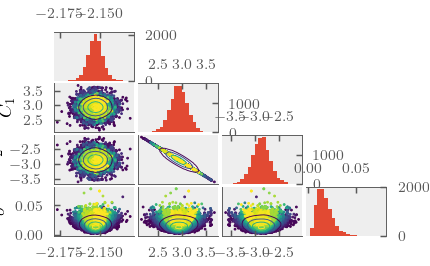

(<Figure size 322.54x199.34 with 10 Axes>,
 {'00': <AxesSubplot:label='00'>,
  '10': <AxesSubplot:label='10', ylabel='$C_{1}$'>,
  '11': <AxesSubplot:label='11'>,
  '20': <AxesSubplot:label='20', ylabel='$C_{2}$'>,
  '21': <AxesSubplot:label='21'>,
  '22': <AxesSubplot:label='22'>,
  '30': <AxesSubplot:label='30', xlabel='$C_{0}$', ylabel='$\\sigma$'>,
  '31': <AxesSubplot:label='31', xlabel='$C_{1}$'>,
  '32': <AxesSubplot:label='32', xlabel='$C_{2}$'>,
  '33': <AxesSubplot:label='33'>})

In [93]:
post_exp.summary()
marginal_plot(post_exp)

<IPython.core.display.Javascript object>


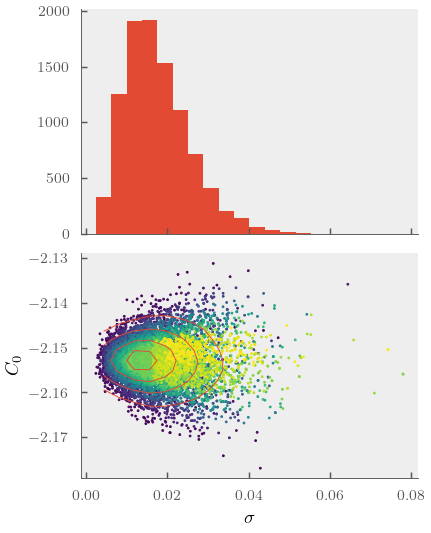

In [94]:
fig = newfig(height=2, addax=False, constrained_layout=True)
single_marginal(post_exp, 'sigma', 'C0', fig=fig, contourkw={'colors': 'C0'})
savefig(fig, 'exponential_marginal_de.pdf')

### Halfnormal Noise

In [95]:
mu = -0.00014565
sigma = 0.0049039

model = LogpolyModel(order=2) + HalfNormalNoise(mu, sigma)
data_hn = ResponseData(model, label='DE')
data_hn.cut(E_low=2000, E_high=10000)
run_multinest(data_hn, n_live_points=2000);
post_hn = Posterior(data_hn)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 2000
 dimensionality =    4
 *****************************************************
  analysing data from DElogpoly2HN-0.000145650.0049039/mn_.txt ln(ev)=  -28.718395167936038      +/-  0.11324148939406942     
 Total Likelihood Evaluations:       153763
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


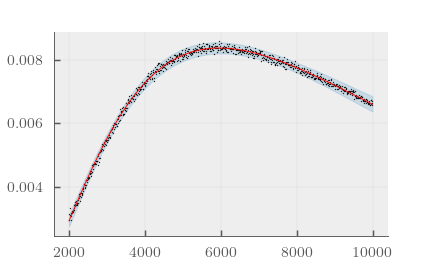

In [96]:
gridon()
fig, ax = newfig(N=1)
plt.grid(True, zorder=-2, lw=0.1)
data_hn.plot(ax=ax, log=False, color='k', s=0.05)
post_hn.plot(ax=ax, color='r', quantile=None)
post_hn.plot_quantiles(ax=ax, color='C1', alpha=0.2)
savefig(fig, 'halfnormal_de.pdf')
gridoff()

Posterior for LogpolyModel + HalfNormalNoise
Nested sampling global log evidence:            -28.71839517 ± 0.11324149
Nested importance sampling global log evidence: -29.04411193 ± 0.12666595

Param        Mean               Std
C0           -2.15295136   ± 0.00345913
C1           2.93273387    ± 0.13932914
C2           -2.86624291   ± 0.13928961
sigma        0.00936907    ± 0.00290194

Param         Maximum Likelihood \ MAP
C0           -2.15326034e+00
C1           2.97173055e+00
C2           -2.90766292e+00
sigma        2.12986827e-02



<IPython.core.display.Javascript object>


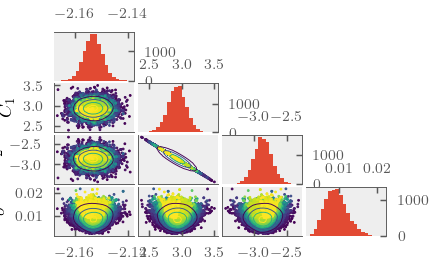

In [98]:
post_hn.summary()
marginal_plot(post_hn);

<IPython.core.display.Javascript object>


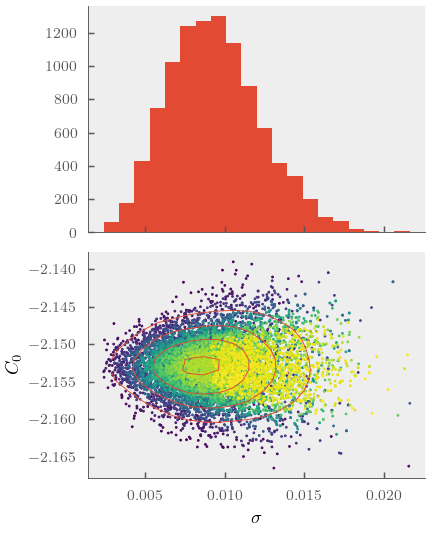

In [102]:
fig = newfig(height=2, addax=False, constrained_layout=True)
single_marginal(post_hn, 'sigma', 'C0', fig=fig, contourkw={'colors': 'C0'}, bins=20)
savefig(fig, 'halfnormal_marginal_de.pdf')

## Compare log

In [189]:
sigma = 0.00894
orders = list(range(1, 6))
datas = []
for order in orders:
    model = LogpolyModel(order=order) + ConstantNoise(sigma)
    data = ResponseData(model, label='DE')
    data.cut(E_low=2000, E_high=10000)
    run_multinest(data, n_live_points=500);
    datas.append(data)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    2
 *****************************************************
  analysing data from DElogpoly1CN0.00894/mn_.txt ln(ev)=  -243.81094607042945      +/-  0.19478494380359027     
 Total Likelihood Evaluations:        14994
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2CN0.00894/mn_.txt ln(ev)=  -27.797795607561074      +/-  0.22274525451687127     
 Total Likelihood Evaluations:        20581
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of l

In [190]:
log_posts = [Posterior(data) for data in datas]

ML is not equal to MAP


In [225]:
sigma = 0.00894
sigma = 0.0003
orders = list(range(1, 13))
datas_FE = []
for order in orders:
    model = LogpolyModel(order=order) + ConstantNoise(sigma)
    data = ResponseData(model, label='FE')
    data.cut(E_low=2000, E_high=10000)
    run_multinest(data, n_live_points=500);
    datas_FE.append(data)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    2
 *****************************************************
  analysing data from FElogpoly1CN0.0003/mn_.txt ln(ev)=  -596.43460507545115      +/-  0.21209962697242465     
 Total Likelihood Evaluations:        16625
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from FElogpoly2CN0.0003/mn_.txt ln(ev)=  -37.357736621580550      +/-  0.24422688704394960     
 Total Likelihood Evaluations:        24137
 Sampling finished. Exiting MultiNest

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of liv

In [227]:
post_FE = [Posterior(d) for d in datas_FE]

ML is not equal to MAP


<IPython.core.display.Javascript object>


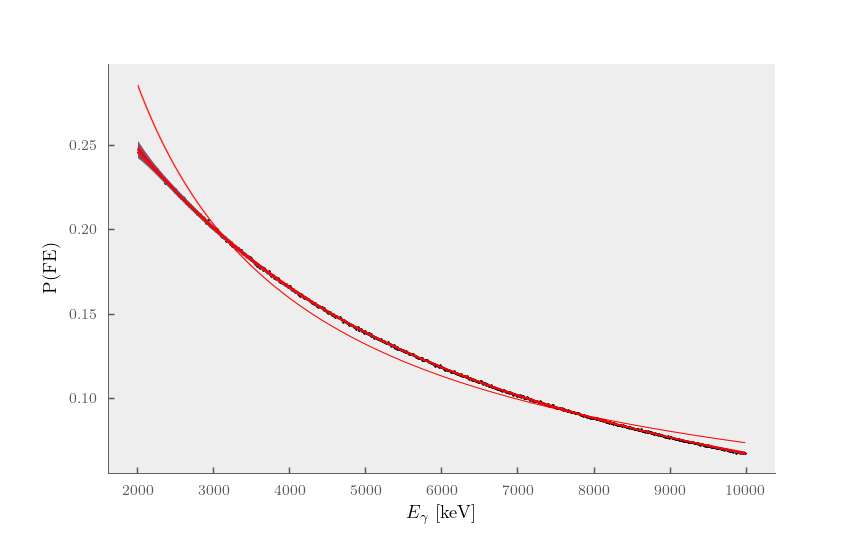

Posterior for LogpolyModel + ConstantNoise
Nested sampling global log evidence:            -596.43460508 ± 0.21209963
Nested importance sampling global log evidence: -596.48981328 ± 0.02104458

Param        Mean               Std
C0           -0.91524083   ± 0.00061838
C1           -0.16025305   ± 0.00060952


C0           -9.15232707e-01
C1           -1.60287087e-01

MAP
-9.15567212e-01
-1.59465476e-01

0.950: 0.043 0.04479283314669653
0.990: 0.054 0.054360880393421074
0.999: 0.066 0.06639931546064212
Posterior for LogpolyModel + ConstantNoise
Nested sampling global log evidence:            -37.35773662 ± 0.24422689
Nested importance sampling global log evidence: -37.64443311 ± 0.01857020

Param        Mean               Std
C0           -0.91523532   ± 0.00061868
C1           0.67704032    ± 0.02518234
C2           -0.83755668   ± 0.02518988

Param         Maximum Likelihood \ MAP
C0           -9.15176876e-01
C1           6.79301652e-01
C2           -8.39773312e-01

0.950: 0.628 0.66

0.950: 0.970 1.0210131084908767
0.990: 0.992 1.0025157709763468
0.999: 0.996 0.997242549182474
Posterior for LogpolyModel + ConstantNoise
Nested sampling global log evidence:            -45.35997613 ± 0.28575191
Nested importance sampling global log evidence: -48.23579455 ± 0.01295269

Param        Mean               Std
C0           -0.91522183   ± 0.00060348
C1           -0.92195218   ± 26.53901315
C2           2.01242334    ± 55.05512080
C3           -0.13222903   ± 52.25962875
C4           -0.80371103   ± 53.96485222
C5           0.54345502    ± 55.51609383
C6           -1.59759016   ± 53.91604440
C7           -0.25066125   ± 54.52157978
C8           -0.75402329   ± 54.32650604
C9           0.64424725    ± 53.51562774
C10          1.67159990    ± 53.13018854
C11          1.57886362    ± 54.76876973
C12          -2.15212695   ± 28.37165184

Param         Maximum Likelihood \ MAP
C0           -9.14964256e-01
C1           1.79137953e+01
C2           -5.21283782e+01
C3           4.8626

In [229]:
fig, ax = newfig(N=2)
data = datas_FE[0]
data.plot(ax=ax, zorder=-1, color='k', log=False)
for post in post_FE:
    post.plot(ax=ax)
    print(post.summary())
    post._assess()

<IPython.core.display.Javascript object>


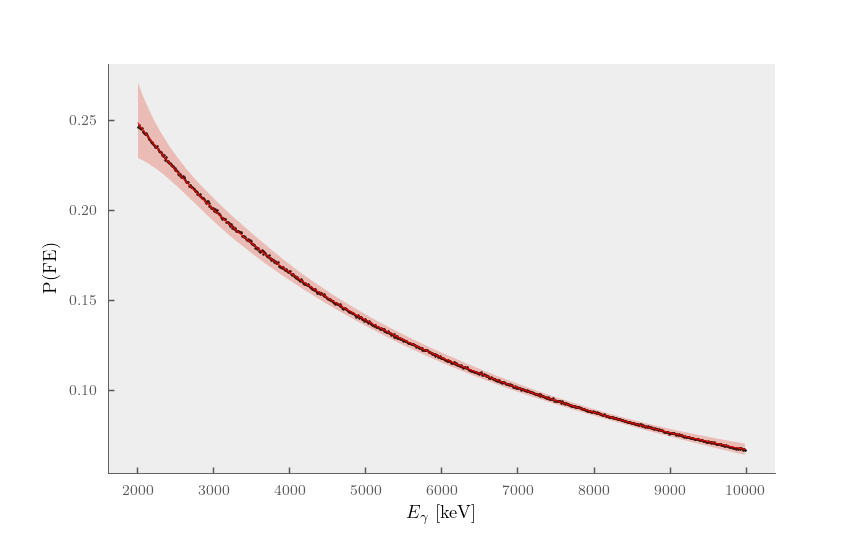

<AxesSubplot:xlabel='$E_{\\gamma}$ [keV]', ylabel='P(FE)'>

In [214]:
fig, ax = newfig(N=2)
data = datas_FE[0]
data.plot(ax=ax, zorder=-1, color='k', log=False)
post_FE[2].plot(ax=ax)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =   10
 *****************************************************
  analysing data from FElogpoly9CN0.0003/mn_.txt ln(ev)=  -43.502856811285028      +/-  0.28026064432529713     
 Total Likelihood Evaluations:        79610
 Sampling finished. Exiting MultiNest



/home/erdos/gits/CompSci3/notebooks/../src/utils.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(fig_size[0], fig_size[1]), **kwargs)


<IPython.core.display.Javascript object>


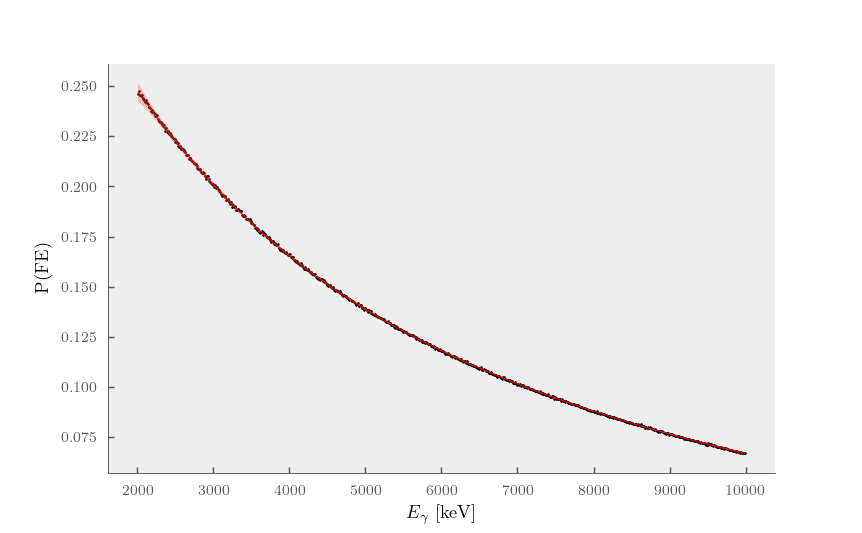

<AxesSubplot:xlabel='$E_{\\gamma}$ [keV]', ylabel='P(FE)'>

In [326]:
sigma = 0.0003
model = LogpolyModel(order=9) + ConstantNoise(sigma)
data = ResponseData(model, label='FE')
data.cut(E_low=2000, E_high=10000)
run_multinest(data, n_live_points=500);
fig, ax = newfig(N=2)
data.plot(ax=ax, zorder=-1, color='k', log=False)
Posterior(data).plot(ax=ax)

In [327]:
p = Posterior(data)
p._assess()

0.950: 0.951 1.0012515644555695
0.990: 0.991 1.0012515644555695
0.999: 0.994 0.9947369146367895


In [153]:
y_i ~ N(y_tilde_i, sigma)
^
||?
v
log y_i ~ N(log(y_tilde_i), sigma_log)
log(y_i) - log(y_rolling_mean_i) ~ N(x, y)

Prior på sigma

SyntaxError: invalid syntax (2760401709.py, line 1)

### Empirical sigmas

In [84]:
model = LogpolyModel(order=2) + EmpiricalNoise(res)
data_emp = ResponseData(model, label='DE')
data_emp.cut(E_low=2000, E_high=10000)
run_multinest(data_emp, n_live_points=500);
post_emp = Posterior(data_emp)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    3
 *****************************************************
  analysing data from DElogpoly2Sigmas-0.006450454720658971/mn_.txt ln(ev)=  -27.854501652321410      +/-  0.23270000058626877     
 Total Likelihood Evaluations:        19137
 Sampling finished. Exiting MultiNest



<IPython.core.display.Javascript object>


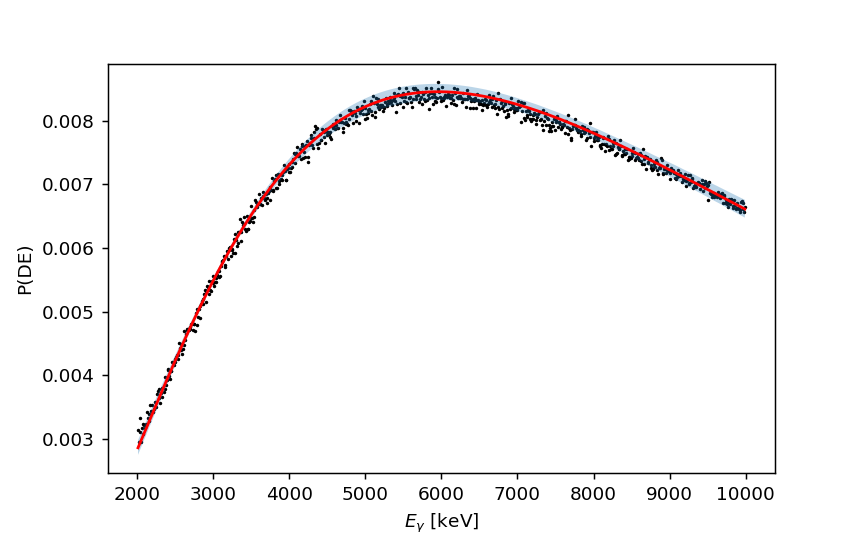

<AxesSubplot:xlabel='$E_{\\gamma}$ [keV]', ylabel='P(DE)'>

In [85]:
fig, ax = newfig(N=2)
data_emp.plot(ax=ax, zorder=-1, color='k', log=False)
post_emp.plot(ax=ax)

<IPython.core.display.Javascript object>


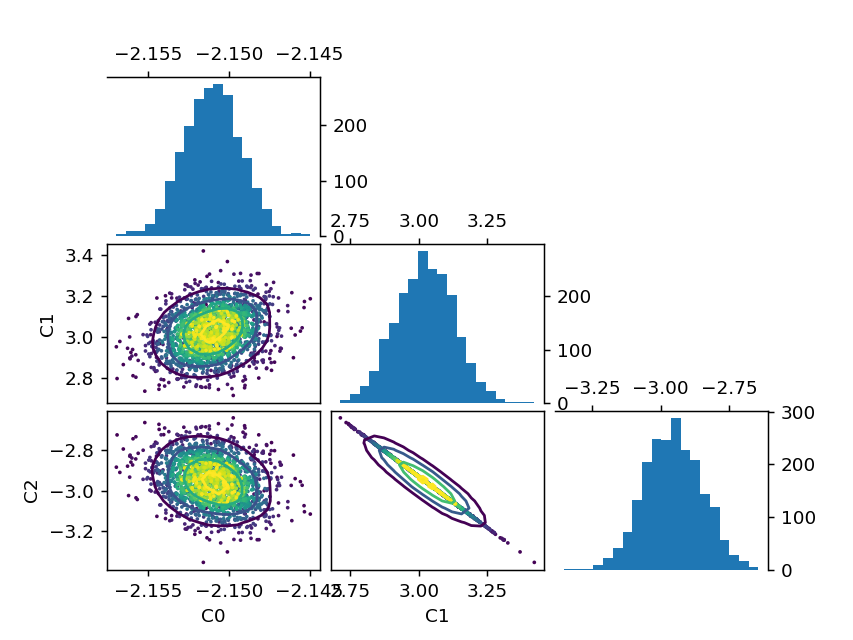

(<Figure size 640x480 with 6 Axes>,
 {'00': <AxesSubplot:label='00'>,
  '10': <AxesSubplot:label='10', ylabel='C1'>,
  '11': <AxesSubplot:label='11'>,
  '20': <AxesSubplot:label='20', xlabel='C0', ylabel='C2'>,
  '21': <AxesSubplot:label='21', xlabel='C1'>,
  '22': <AxesSubplot:label='22'>})

In [86]:
marginal_plot(post_emp)

In [168]:
1 - np.exp(- 0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])